In [3]:
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')
import numpy as np
import pandas as pd
import xarray as xr

import wandb
import xgboost as xgb
import re

from importlib import reload

# Import Omphalos modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
from analysis import helper as hp

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


random_state = 69
np.random.state = random_state
np.random.seed = random_state

In [4]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_na_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_na+.pkl')
TrainSet_cl_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_cl-.pkl')

In [5]:
# Rename all the keys in train_set_cl so that they follow on
# from the previous dictionary; this allows merging
TrainSet_na_len = len(TrainSet_na_dict.keys())
TrainSet_cl_len = len(TrainSet_na_dict.keys())
TrainSet_cl_arr = []
for key in TrainSet_cl_dict.keys():
    TrainSet_cl_arr.append(key)

for _ in TrainSet_cl_arr:
    old_key = _
    new_key = _ + TrainSet_na_len
    TrainSet_cl_dict[new_key] = TrainSet_cl_dict[old_key]
    del TrainSet_cl_dict[old_key]

# Merge the Na+ and Cl- charge balanced dictionaries
TrainSet_dict = TrainSet_na_dict | TrainSet_cl_dict

In [6]:
# Filter any error filled runs and create errorless datasets
dataset_all_dict, error_all_dict = hp.filter_errors(TrainSet_dict)
dataset_na_dict, error_na_dict = hp.filter_errors(TrainSet_na_dict)
dataset_cl_dict, error_cl_dict = hp.filter_errors(TrainSet_cl_dict)

Returned 5316 files without errors out of a total possible 10000.
4684 files had errors.
0 files had unhandled errors.
File failure rate: 88.11136192626034 %.
To see unhandled errors, run with verbose=True.
Returned 2471 files without errors out of a total possible 5000.
2529 files had errors.
0 files had unhandled errors.
File failure rate: 102.34722784297855 %.
To see unhandled errors, run with verbose=True.
Returned 2845 files without errors out of a total possible 5000.
2155 files had errors.
0 files had unhandled errors.
File failure rate: 75.7469244288225 %.
To see unhandled errors, run with verbose=True.


In [7]:
attributes_all_df = attr.get_condition(dataset_all_dict,"basalt",species_concs=True)
attributes_all_df = attributes_all_df.loc[:, ['Ca++', 'Fe++', 'Mg++', 'HCO3-']]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++,HCO3-
0,0.000030,0.000262,0.000121,0.82
1,0.000071,0.000244,0.000245,0.82
2,0.000183,0.000048,0.000124,0.82
3,0.000157,0.000085,0.000127,0.82
4,0.000053,0.000019,0.000237,0.82
...,...,...,...,...
5311,0.000263,0.000020,0.000210,0.82
5312,0.000245,0.000107,0.000123,0.82
5313,0.000176,0.000031,0.000255,0.82
5314,0.000272,0.000215,0.000171,0.82


In [8]:
def get_condition_ph(complete_dict, condition):
    index_vals = []
    ph_vals = []
    for _ in complete_dict.keys():
        index_vals.append(_)
        ph_vals.append(complete_dict[_].condition_blocks[condition].contents['pH'])
    ph_df = pd.DataFrame(ph_vals, index=index_vals, columns=['pH'])
    ph_df = ph_df.reset_index(drop=True)
    return ph_df

ph_df = get_condition_ph(dataset_all_dict, "basalt")

attributes_all_df =  pd.concat([attributes_all_df, ph_df], axis=1)
attributes_all_df

,Ca++,Fe++,Mg++,HCO3-,pH
0,0.000030,0.000262,0.000121,0.82,4.533987010208772
1,0.000071,0.000244,0.000245,0.82,4.6355729656454905
2,0.000183,0.000048,0.000124,0.82,4.266688527662164
3,0.000157,0.000085,0.000127,0.82,4.93744987421191
4,0.000053,0.000019,0.000237,0.82,4.320066725459632
...,...,...,...,...,...
5311,0.000263,0.000020,0.000210,0.82,3.5183910175187125
5312,0.000245,0.000107,0.000123,0.82,3.036155925072882
5313,0.000176,0.000031,0.000255,0.82,3.4486894430649
5314,0.000272,0.000215,0.000171,0.82,3.747021276313699


In [9]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [10]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [11]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions
FinalVols_ds = lbls.raw(dataset_all_dict, 'volume')
FinalVols_ds = NrFormatFixer_XYZTime(FinalVols_ds)
FinalVols_ds = FinalVols_ds.astype(float)

InitialVols_ds = attr.initial_conditions(dataset_all_dict, concentrations=False, minerals=True)
InitialVols_ds = NrFormatFixer_XYZ(InitialVols_ds)
InitialVols_ds = InitialVols_ds.astype(float)

# Generation of an xarray dataset representing change in mineralogical volume fractions
DeltVolFrac_ds = FinalVols_ds - InitialVols_ds

# Generation of an narrowed-down xarray dataset containing only data on a specific time and place
DeltVolFrac_TenYr_ds = DeltVolFrac_ds.sel(X=0.5,Y=0.5,Z=0.5,time=10)

# Generation of an additional xarray variable entitled Carbonates; placed into the above xarray dataset
DeltVolFrac_TenYr_ds = DeltVolFrac_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_TenYr_ds: DeltVolFrac_TenYr_ds.Calcite + DeltVolFrac_TenYr_ds.Siderite + DeltVolFrac_TenYr_ds.Magnesite)

In [12]:
# For the ML problem define attributes and labels datasets
attributes = attributes_all_df
labels = DeltVolFrac_TenYr_ds

# Split the ML datasets into x's (predictor arrays) and y's (target arrays)
x = attributes.loc[:, ['Ca++', 'Fe++','Mg++', 'pH']].astype(float)
y = DeltVolFrac_TenYr_ds.Carbonates.values.astype(float)

# Generate a numpy matrix from a pandas dataframe
x = x.to_numpy()

# Normalisation array for each of the columns in x
# Essentially the top values that are found in each of these columns
x_norm = [3.0E-4, 3.0E-4, 3.0E-4, 5]

# Normalisation of the np matrix using the x_norm array
for i, norm in enumerate(x_norm):
    x[:, i] = x[:, i]/norm

# Generate a vertical array of target values.
y = y.reshape(-1,1)
# y = y * 1e4 ?? Is this normalisation Angus? If so, I'd have done it like this:
y_norm = max(y)
y = y / y_norm

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

In [15]:
%%time

xgb_defaults = {
    'tree_method': 'hist',
    'gamma': 0,
    'mds': 0,
    'eta': 0.01,
    'l1' : 0,
    'l2' : 1,
    'max_depth' : 0,
    'max_leaves': 6,
    'objective': 'reg:squarederror',
    'max_bin': 10000,
    'grow_policy': 'lossguide'
}

config_defaults = {
    'tree_method': 'hist',
    'gamma': 0,
    'mds': 0,
    'eta': 0.009829,
    'l1' : 0.09512,
    'l2' : 6.852,
    'max_depth' : 13,
    'objective': 'reg:pseudohubererror'
}

config_defaults = {
    'tree_method': 'hist',
    'gamma': 0,
    'mds': 0,
    'eta': 0.007711,
    'l1' : 9.942,
    'l2' : 6.002,
    'max_depth' : 11,
    'objective': 'reg:pseudohubererror'
}

wandb.init(config=xgb_defaults, project='bcm_4-0')

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

params = {'max_depth': wandb.config.max_depth,
            'tree_method': wandb.config.tree_method,
            'max_delta_step': wandb.config.mds,
            'eta': wandb.config.eta,
            'objective': wandb.config.objective,
            'alpha': wandb.config.l1,
            'lambda': wandb.config.l2,
            'gamma': wandb.config.gamma,
            'max_leaves': wandb.config.max_leaves,
            'max_bin': wandb.config.max_bin,
            'grow_policy': wandb.config.grow_policy
        }

# Use nested list to define feature interaction constraints
#params_constrained['interaction_constraints'] = '[[0], [1, 2, 3, 4]]'
#params_constrained['monotone_constraints'] = "(1,0,1,0,0)"

results = {}

num_round = 50000
bst = xgb.train(params, dtrain, num_round, evallist, evals_result=results, verbose_eval=False, callbacks=[wandb.xgboost.WandbCallback()])
wandb.log({"val_loss" : results['rmse'][-1]})

KeyError: 'mphe'

Text(-0.1, 1.05, '(a)')

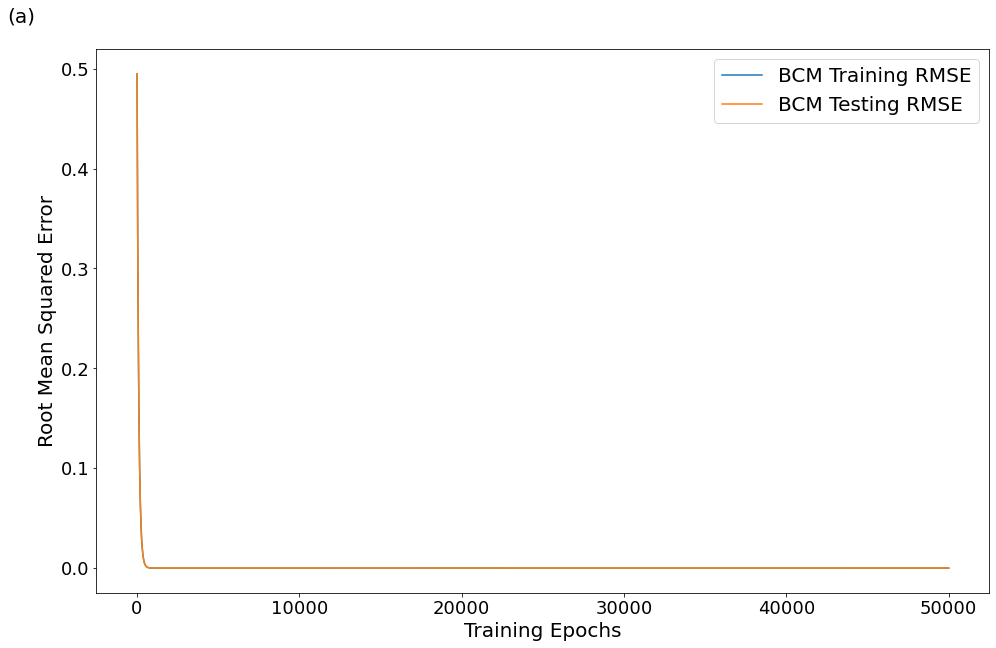

In [31]:
from matplotlib import pyplot

loss_key = 'rmse'
fontsize = 20

epochs = len(results['train'][loss_key])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(x_axis, (results['train'][loss_key]), label='BCM Training RMSE')
ax.plot(x_axis, (results['eval'][loss_key]), label='BCM Testing RMSE')
# ax.set_ylim(0, 0.00004)
ax.legend(fontsize=fontsize)
ax.tick_params('both', labelsize=18)
ax.set_ylabel('Root Mean Squared Error', fontsize=fontsize)
ax.set_xlabel('Training Epochs', fontsize=fontsize)
ax.text(-0.1, 1.05, '(a)', transform=ax.transAxes, size=20)
# fig.savefig('figures/rifle_training.png', dpi=300)


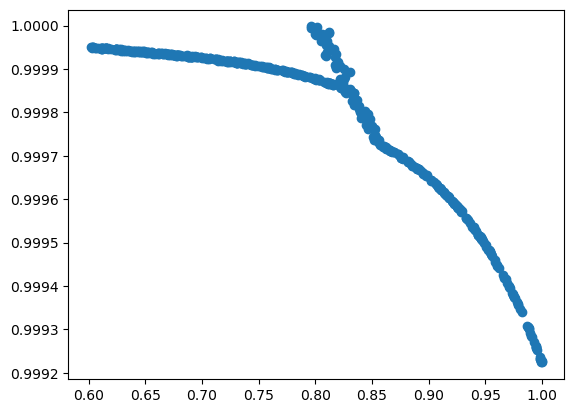

In [49]:
# Plot Normalised [Ca++] vs Normalised Tot. Carbonates in Eval Data
# x_test ca fe mg ph
# y_test carbonates
x = x_test[:,3]
y = y_test










plt.scatter(x, y)

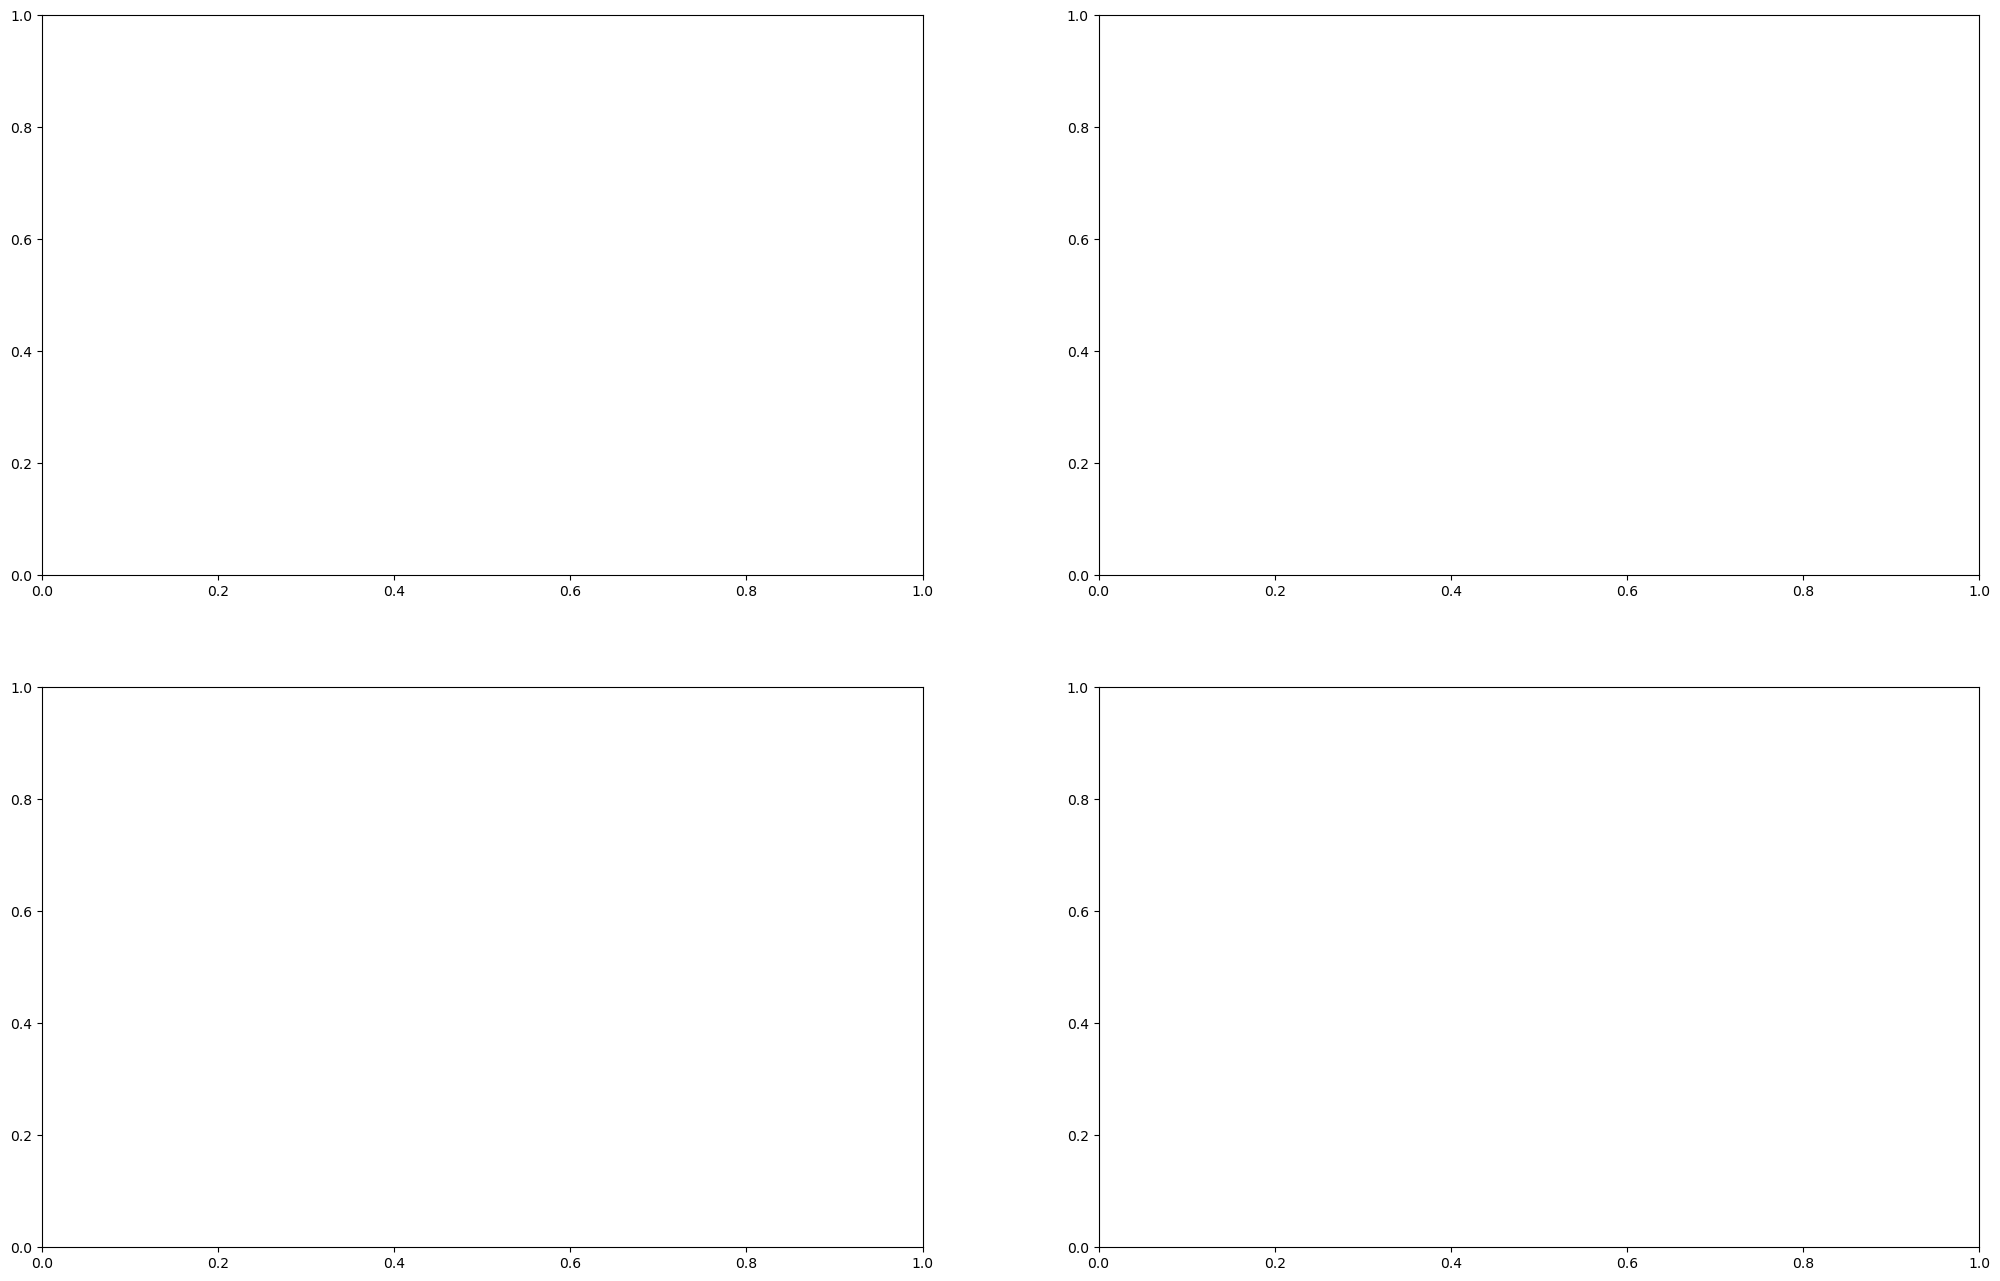

In [42]:
fig = plt.figure(figsize=(25, 16))

plt.style.use('default')

# Generate uneven subplots
sub1 = fig.add_subplot(2,2,1)
sub2 = fig.add_subplot(2,2,2)
sub3 = fig.add_subplot(2,2,3)
sub4 = fig.add_subplot(2,2,4)

axis_list = [sub1, sub2, sub3, sub4]

species_list = ['Ca++', 'Fe++','Mg++', 'pH']
axis_labels = ['[Ca++] (arb.)', '[Fe++] (arb.)','[Mg++] (arb.)', 'pH (arb.)']

samples = 30
dims = 4
plot_vars = np.arange(dims)

predict_range = (0,1)

defaults = np.ones((samples, dims))

defaults[:,0] = 1.5
defaults[:,1] = 8.8
defaults[:,2] = 5.4
defaults[:,3] = 9.7
n=0

x_norm = [3.0E-4, 3.0E-4, 3.0E-4, 5]

for plot_var, x_label, species, ax, norm in zip(plot_vars, axis_labels, species_list, axis_list, x_norm):
    defaults = np.ones((samples, dims))
    # Default (Druhan 2014)
    defaults[:,0] = 1.5 / 3.0E-4
    defaults[:,1] = 8.8 / 3.0E-4
    defaults[:,2] = 5.4 / 3.0E-4
    defaults[:,3] = 9.7 / 5
    path = '/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/{}.pkl'.format(species)

    defaults[:,plot_var] =  np.linspace(predict_range[0], predict_range[1], len(defaults[:, plot_var]))
    
    ypred = bst.predict(xgb.DMatrix(defaults))
    ypred = (ypred / (0.6389136261 * 100)) * 100

    sweep_x, sweep_y = gpfp.get_sweep(path, species, 'amendment', ('FeS(am)', 'FeS34(am)'))
    sweep_y = (sweep_y / (0.6389136261 * 100)) * 100
    ax.plot(defaults[:, plot_var] * x_norm[plot_var], ypred * 1e-4, label='GBTree fit')
    
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel('Percentage vol. frac. increase (%)', fontsize=20)
    ax.tick_params('both', labelsize=18)
    ax.set_xlim(-1, 31)
    ax.set_ylim(-0.003, 0.09)

    ax.text(-0.1, 1.05, '({})'.format(string.ascii_lowercase[n]), transform=ax.transAxes, size=20)
    
    n = n+1
            
    ax.scatter(sweep_x, sweep_y, c="k", marker='+', s=100,label='RTM results')
    
    
sub5.legend(('GBT fit', 'RTM results'), fontsize=20, bbox_to_anchor=(1, 0, 1, 1), loc="lower left", ncol=1)